### This script allows to load OLR data, detect cloud bands and then do the inheritance tracking

In [1]:
import datetime as dt
import os
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
from matplotlib.ticker import MultipleLocator
import cartopy.crs as ccrs

from cloudbandpy.cb_detection import detection_workflow
from cloudbandpy.figure_tools import set_fontsize
from cloudbandpy.io_utilities import (
    load_ymlfile,
    load_list,
    subset_latitudes,
    subset_longitudes,
)
from cloudbandpy.load_driver import run_load_data
from cloudbandpy.misc import wrapTo180
from cloudbandpy.time_utilities import (
    create_list_of_dates,
    add_startend_datetime2config,
)
from cloudbandpy.tracking import tracking

Load configuration file and make adjustements for this test case

In [2]:
base_dir = "../../"

config_file = os.path.join(base_dir, "config/config_cbworkflow_southPacific.yml")
config = load_ymlfile(config_file, isconfigfile=True)
config_event = config.copy()
# Make sure that the period for the cloud bands cover the same period as the example data
config_event["startdate"] = "20210226.00"
config_event["enddate"] = "20210228.00"

dirdata = "data/"
config_event["clouddata_path"] = os.path.join(base_dir, "data")
config_event["parameters_file"] = os.path.join(
    base_dir, "parameters/parameters_southhemisphere.yml"
)
# No need to save any files
config_event["load_saved_files"] = False
config_event["save_dailyvar"] = False
config_event["save_listcloudbands"] = False
print(config)

2024-01-12 14:48:48,937 - io_utilities.load_ymlfile - INFO: Configuration file loaded


{'run_inheritance_tracking': True, 'startdate': '20160101.00', 'enddate': '20160130.00', 'domain': 'southPacific', 'hemisphere': 'south', 'lon_west': 130, 'lon_east': 290, 'lat_north': 5, 'lat_south': -50, 'clouddata_path': './ERA5/netcdf/3hourly/surface_level/', 'varname_infilename': 'top_net_thermal_radiation', 'qd_var': True, 'datatimeresolution': 3.0, 'period_detection': 24.0, 'olr_convert2wm2': True, 'varname': 'ttr', 'timecoord_name': 'time', 'xcoord_name': 'longitude', 'ycoord_name': 'latitude', 'select_djfm': False, 'parameters_file': './cloudbandPy/parameters/parameters_southhemisphere.yml', 'saved_dirpath': './cloud_band_files', 'save_dailyvar': False, 'save_listcloudbands': True, 'load_saved_files': False, 'dir_figures': './cloud_band_figures', 'fig_detection_process': False, 'fig_time_evolution_object': False, 'fig_time_evolution_var_cloudband': False, 'fig_overlay_cloudband': False, 'fig_show_bbox_around_blobs': False, 'fig_inheritance_tracking': False, 'fig_density': Fals

Load cloud bands from the South Pacific for the dates specified in the analyses config file

In [3]:
add_startend_datetime2config(config_event)
listofdates = create_list_of_dates(config_event)
print(str(len(listofdates))+" dates created from "+str(listofdates[0])+" to "+str(listofdates[-1]))

3 dates created from 2021-02-26 00:00:00 to 2021-02-28 00:00:00


Load data

In [4]:
olr2process, parameters, lats, lons, resolution = run_load_data(config_event)

2024-01-12 14:48:49,034 - load_driver.run_load_data - INFO: Loading data and parameters 
2024-01-12 14:48:49,038 - io_utilities.load_ymlfile - INFO: Parameters file loaded
2024-01-12 14:48:49,038 - io_utilities.load_dataset - INFO: Loading dataset from ../../data
2024-01-12 14:48:49,039 - io_utilities.load_dataset - INFO: Loading 2021 --> 2021
2024-01-12 14:48:52,067 - io_utilities.get_variable_lonlat_from_domain - INFO: Subsetting dataset on domain done
2024-01-12 14:48:52,070 - io_utilities.make_daily_average - INFO: Computation of daily average
2024-01-12 14:48:52,158 - io_utilities.make_daily_average - INFO: Computation of daily average done
2024-01-12 14:48:52,160 - io_utilities.load_dataset - INFO: Dataset loaded


We are initializing a new 4D array to represent a 3D map with dimensions (time, longitude, latitude) and introducing an extra dimension to accommodate OLR threshold values.

In [5]:
thresholds_list = [180, 190, 200, 210, 220, 230, 240]

Run detection

In [6]:
list_of_cloud_bands_all_threshold=[]
for ithresh in thresholds_list:
    parameters["OLR_THRESHOLD"] = ithresh
    (
            _,
            _,
            _,
            _,
            _,
            _,
            list_of_cloud_bands,
        ) = detection_workflow(
            var2process=olr2process,
            parameters=parameters,
            latitudes=lats,
            longitudes=lons,
            resolution=resolution,
            listofdates=listofdates,
            config=config,
        )
    list_of_cloud_bands = tracking(list_of_cloud_bands, resolution, overlapfactor=parameters["othresh"])
    list_of_cloud_bands_all_threshold.append(list_of_cloud_bands)


2024-01-12 14:48:52,231 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2024-01-12 14:48:52,606 - cb_detection.detection_workflow - INFO: Cloud band detection done
2024-01-12 14:48:52,607 - cloudbandpy.tracking - INFO: Inheritance tracking in progress
2024-01-12 14:48:52,608 - cloudbandpy.tracking - INFO: Inheritance tracking done
2024-01-12 14:48:52,608 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2024-01-12 14:48:52,630 - cb_detection.detection_workflow - INFO: Cloud band detection done
2024-01-12 14:48:52,630 - cloudbandpy.tracking - INFO: Inheritance tracking in progress
2024-01-12 14:48:52,631 - cloudbandpy.tracking - INFO: Inheritance tracking done
2024-01-12 14:48:52,632 - cb_detection.detection_workflow - INFO: Cloud band detection in progress
2024-01-12 14:48:52,657 - cb_detection.detection_workflow - INFO: Cloud band detection done
2024-01-12 14:48:52,658 - cloudbandpy.tracking - INFO: Inheritance tracking in progress
2

Import longitudes and latitudes for the map

In [7]:
lons_globe = np.arange(0,360,.5)
lats_globe = np.arange(90,-90.5,-.5)
print(lats_globe.all()==lats_globe.all())
# Get longitudes and latitudes of South Pacific domain
_, lonsSP = subset_longitudes(lons_globe, config["lon_west"], config["lon_east"])
_, latsSP = subset_latitudes(lats_globe, config["lat_north"], config["lat_south"])

print(f"Longitudes, min: {lonsSP.min()}, max: {lonsSP.max()}")
print(f"Latitudes, min: {latsSP.min()}, max: {latsSP.max()}")

True
Longitudes, min: 130.0, max: 290.0
Latitudes, min: -50.0, max: 5.0


Plot of cloud bands with different olr thresholds

In [8]:
#Parameters for plot
lat_north, lat_south = round(lats[0]), round(lats[-1])
major_xticks = np.concatenate((np.arange(0, 180, 30), np.arange(-180, 0, 30)))
minor_xticks = np.concatenate((np.arange(0, 180, 10), np.arange(-180, 0, 10)))

major_yticks = np.arange(-80, 100, 20)
minor_yticks = np.arange(-80, 100, 5)

LON_FORMAT = LongitudeFormatter(zero_direction_label=True, degree_symbol="")
LAT_FORMAT = LatitudeFormatter(degree_symbol="")

set_fontsize()

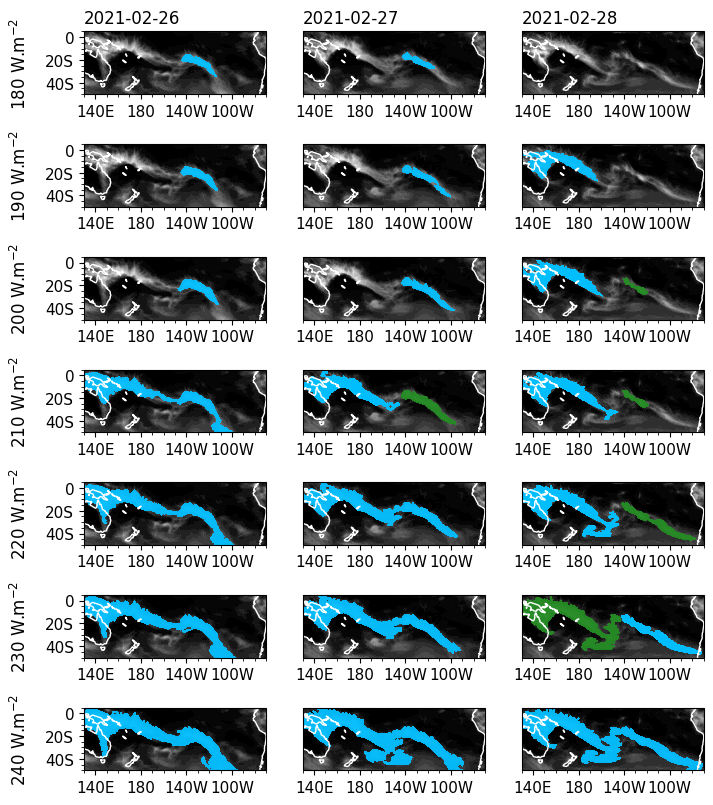

In [13]:
# from matplotlib import rcParams
# rcParams['text.usetex'] = True

fig, axs = plt.subplots(
    nrows=len(thresholds_list),
    ncols=3,
    figsize=(8, 10),
    subplot_kw={"projection": ccrs.PlateCarree(central_longitude=180)},
)
cid = 0

for irow in range(axs.shape[0]):
    cb_map_row = list_of_cloud_bands_all_threshold[irow]
    for icol in range(axs.shape[1]):
        axs[0, icol].set_title(f"{listofdates[icol].strftime('%Y-%m-%d')}", fontsize=12, loc="left")
        if icol == 0:
            axs[irow, icol].text(-0.35, 0.5, fr"{thresholds_list[irow]} W.m$^{{-2}}$", fontsize=12, va="center", ha="center", rotation="vertical", transform=axs[irow, icol].transAxes)
        ax = axs[irow, icol]
        ax.contourf(lons, lats, olr2process[icol], transform=ccrs.PlateCarree(), levels=range(100, 300, 10), cmap="binary", extend="both")
        if len(cb_map_row[icol]):
            map = np.zeros_like(olr2process[0, :, :])
            for i, m in enumerate(cb_map_row[icol]):
                map = map + (i + 2) * m.cloud_band_array
                masked_map = np.ma.masked_where(map == 0, map)
                colorband = ["forestgreen", "deepskyblue"]
                ax.contourf(
                    lons,
                    lats,
                    masked_map,
                    transform=ccrs.PlateCarree(),
                    levels=range(4),
                    alpha=0.95,
                    colors=colorband[: int(masked_map.max())],
                )
        else:
            emap = np.zeros_like(olr2process[0, :, :])
        
        lat_north, lat_south = 10, -50
        ax.set_xticks(major_xticks, crs=ccrs.PlateCarree())
        ax.set_xticks(minor_xticks, minor=True)
        ax.xaxis.set_major_formatter(LON_FORMAT)
        ax.xaxis.set_major_locator(MultipleLocator(40))
        if icol == 0:
            ax.set_yticks(major_yticks, crs=ccrs.PlateCarree())
            ax.set_yticks(minor_yticks, minor=True)
            ax.yaxis.set_major_formatter(LAT_FORMAT)
        else:
            ax.tick_params(axis="y", which="both", left=False, labelleft=False)

        ax.coastlines("110m", color="white")
        ax.set_extent([wrapTo180(lons)[-1], wrapTo180(lons)[0], lat_south, lat_north])
        ax.set_ylim([lat_south, lat_north-5])
        original_startdate = config_event["startdate"]
        datetime_obj = dt.datetime.strptime(original_startdate, "%Y%m%d.%H")
        formatted_startdate = datetime_obj.strftime("%Y-%m-%d")
        cid += 1


fig.savefig("./sensitivity_test.png", dpi=300, bbox_inches="tight")